In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Import Data

In [2]:
valid_data = pd.read_csv('valid_data.csv')
valid_data.head(5)

,fname,label,manually_verified,Duration
0,00044347.wav,Hi-hat,0,14.00
1,001ca53d.wav,Saxophone,1,10.32
2,0033e230.wav,Glockenspiel,1,8.00
3,00353774.wav,Cello,1,4.52
4,003b91e8.wav,Cello,0,13.28


In [3]:
valid_data.shape

(5580, 4)

In [4]:
valid_data['Duration'].hist(bins = 27)

# Change duration for spectrogram

In [5]:
# Example of a Hi Hat spectrogram
y, sr = librosa.load('audio_train/00044347.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

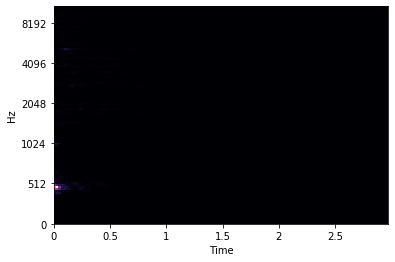

In [6]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [7]:
# Example of a Saxophone spectrogram
y, sr = librosa.load('audio_train/001ca53d.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

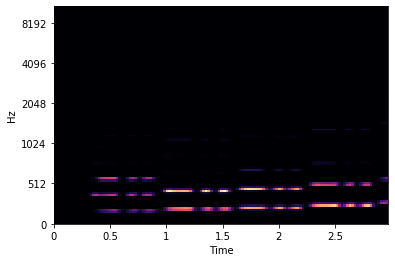

In [8]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

# Create spectrograms for all data 

# ADJUST DURATION + SHAPE + VERIFIED

In [9]:
valid_data.shape

(5580, 4)

In [10]:
valid_data['path'] = 'audio_train/' + valid_data['fname']

# Select verified audio
#valid_data = valid_data.loc[valid_data['manually_verified'] == 1]

# Add numerical values
valid_data['value'] = pd.factorize(valid_data.label)[0]

valid_data.head(20)

,fname,label,manually_verified,Duration,path,value
0,00044347.wav,Hi-hat,0,14.00,audio_train/00044347.wav,0
1,001ca53d.wav,Saxophone,1,10.32,audio_train/001ca53d.wav,1
2,0033e230.wav,Glockenspiel,1,8.00,audio_train/0033e230.wav,2
3,00353774.wav,Cello,1,4.52,audio_train/00353774.wav,3
4,003b91e8.wav,Cello,0,13.28,audio_train/003b91e8.wav,3
5,004ad66f.wav,Clarinet,0,7.00,audio_train/004ad66f.wav,4
6,0063ab88.wav,Computer_keyboard,0,29.64,audio_train/0063ab88.wav,5
7,0075d39c.wav,Keys_jangling,0,20.64,audio_train/0075d39c.wav,6
8,0079d310.wav,Writing,0,4.06,audio_train/0079d310.wav,7
9,0091fc7f.wav,Cello,1,5.70,audio_train/0091fc7f.wav,3


In [11]:
valid_data.shape

(5580, 6)

In [12]:
#new = valid_data.head(20)

In [13]:
D = [] # Dataset

for row in valid_data.itertuples():
    y, sr = librosa.load(row.path, duration= 2.97)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (128, 128): continue
    D.append( (ps, row.value) )

In [14]:
print("Number of samples: ", len(D))

Number of samples:  5580


# Split Dataset * STRATIFY

In [15]:
valid_data['label'].nunique()

41

In [19]:
dataset = D
random.shuffle(dataset)

# STRATIFY
train = dataset[:4464]
test = dataset[4464:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 41))
y_test = np.array(keras.utils.to_categorical(y_test, 41))

In [20]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

#model.add(Dense(10))
model.add(Dense(41))
model.add(Activation('softmax'))

In [21]:
model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=['accuracy'])

model.fit(
    x=X_train, 
    y=y_train,
    epochs=12,
    batch_size=128,
    validation_data= (X_test, y_test))

score = model.evaluate(
    x=X_test,
    y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 4464 samples, validate on 1116 samples
Epoch 1/12
4464/4464 [==============================] - 29s 7ms/step - loss: 5.9510 - accuracy: 0.0372 - val_loss: 3.7034 - val_accuracy: 0.0699
Epoch 2/12
4464/4464 [==============================] - 30s 7ms/step - loss: 3.7422 - accuracy: 0.0589 - val_loss: 3.6901 - val_accuracy: 0.0591
Epoch 3/12
4464/4464 [==============================] - 29s 6ms/step - loss: 3.6970 - accuracy: 0.0576 - val_loss: 3.6749 - val_accuracy: 0.0609
Epoch 4/12
4464/4464 [==============================] - 29s 7ms/step - loss: 3.6777 - accuracy: 0.0607 - val_loss: 3.6527 - val_accuracy: 0.0663
Epoch 5/12
4464/4464 [==============================] - 30s 7ms/step - loss: 3.6527 - accuracy: 0.0571 - val_loss: 3.6161 - val_accuracy: 0.0950
Epoch 6/12
4464/4464 [==============================] - 31s 7ms/step - loss: 3.6364 - accuracy: 0.0663 - val_loss: 3.6490 - val_accuracy: 0.0771
Epoch 7/12
4464/4464 [==============================] - 31s 7ms/step - loss: 3.665